In [125]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np
import re
import json
import importlib

import matplotlib.pyplot as plt
import seaborn as sns


from scipy.stats import ttest_ind, mannwhitneyu, f_oneway, kruskal, chi2_contingency, fisher_exact
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

In [ ]:
import pingouin as pg
import scikit_posthocs as sp

In [2]:
def print_title(title, line_length = 60, symbol = '-'):
    separator = symbol * ((line_length - len(title) - 2) // 2)
    print(f"{separator} {title} {separator}")

# EXPERIMENT DESIGN

## SOURCES INGESTION

-----------------------------------------------------------------------------------------

# EXPERIMENT RESULTS

## SOURCES INGESTION

### LOAD

In [ ]:
# Load raw data
file_name = 'ab_test_example_3.csv'
df_raw = pd.read_csv('../data/' + file_name)
display(df_raw.head(5))

# Make a copy
df = df_raw.copy()

# Check dtypes
print_title('INITIAL DATA TYPES')
print(df.dtypes)

### DTYPES

In [4]:
def format_columns(df, datetime_columns=[], int64_columns=[], float64_columns=[], str_columns=[]):
    for col in datetime_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    for col in int64_columns:
        if col in df.columns:
            df[col] = df[col].astype('Int64')  

    for col in float64_columns:
        if col in df.columns:
            df[col] = df[col].astype('float64')

    for col in str_columns:
        if col in df.columns:
            df[col] = df[col].astype('str')
    
    return df

In [ ]:
datetime_columns = ['WHEN_ENTERED_INTO_EXPERIMENT']
int64_columns = ['U_ID', 'PROMOTER_U_ID', 'IS_TREATMENT', 'COUNT_TRANSFERS', 'DAYS_TRANSACTING', 'DISTINCT_RECEIVERS']
float64_columns = ['TOTAL_TRANSFER_AMOUNT']
str_columns = ['VARIANT', 'USER_SEGMENT', 'PROMO_TAG']

# Basic data conversion
df = format_columns(df, datetime_columns, int64_columns, float64_columns, str_columns)

# Check dtypes
print_title('CONVERTED DATA TYPES')
print(df.dtypes)
display(df.head(5))

## DATA CLEANING

### CHECKS

In [6]:
variant_column = 'VARIANT'

In [ ]:
# Quick checks on data
print_title('DF INFO')
display(df.info())

print_title('DF DESCRIBE')
display(df.describe())

# Check distribution of variants
print_title('VARIANT DISTRIBUTION')
display(df[variant_column].value_counts())

### DUPLICATES

In [ ]:
# Check for and drop duplicates in the entire DataFrame
duplicated_rows = df.duplicated().sum()
print('# of duplicated rows: ', duplicated_rows)

if duplicated_rows > 0:
    df = df.drop_duplicates()
    print('Duplicates in the DataFrame removed.')
else:
    print('No duplicates in the DataFrame found.')

In [ ]:
primary_key_column = 'U_ID'
timestamp_column = ''

# Check for duplicates in the unique columns
duplicated_rows = df[df[primary_key_column].duplicated(keep=False)]
print(f'# of duplicated on {primary_key_column} column: {duplicated_rows[primary_key_column].nunique()}')

if not duplicated_rows.empty:
    print(f'Duplicated {primary_key_column} and their rows:')
    display(duplicated_rows.sort_values(by = 'U_ID'))

    # Keep only the first following timestamp column order
    if timestamp_column == '':
        df = df.drop_duplicates(subset=primary_key_column, keep='last')
        print('Kept the most recent row for each duplicated U_ID.')
    else:
        df = df.sort_values(timestamp_column).drop_duplicates(subset=primary_key_column, keep='last')
        print('Kept the most recent row for each duplicated U_ID.')

### NULLS

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print_title('NUMBER OF NULL VALUES')
print(missing_values)

In [11]:
# Fill null columns
df['TOTAL_TRANSFER_AMOUNT'] = df['TOTAL_TRANSFER_AMOUNT'].fillna(0)

### INCONSISTENCIES

In [ ]:
# Checks errors in variant labeling
checks = df[(df['IS_TREATMENT'] == 1) & (df['VARIANT'] != 'PRICE_PROMO')]
display(checks)
checks = df[(df['IS_TREATMENT'] == 0) & (df['VARIANT'] != 'CONTROL')]
display(checks)

## METRICS DEFINITION

In [149]:
# calculate the metrics, use metric_cnt_ or metric_cvr_
df['metric_cnt_total_transfer_amount'] = df['TOTAL_TRANSFER_AMOUNT']
df['metric_cvr_transaction'] = df['TOTAL_TRANSFER_AMOUNT'].apply(lambda x: 1 if x > 0 else 0, 1)

## DATA ANALYSIS

In [95]:
def remove_outliers(df, metric_column, factor=1.5, threshold=0.1):
    q1 = df[metric_column].quantile(0.2)
    q3 = df[metric_column].quantile(0.8)
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr

    print("Low outlier limit:", lower_bound)
    print("Upper outlier limit:", upper_bound)

    initial_count = df.shape[0]
    df_filtered = df.loc[(df[metric_column] >= lower_bound) & (df[metric_column] <= upper_bound)]
    final_count = df_filtered.shape[0]
    removed_percentage = (initial_count - final_count) / initial_count

    print(f"Filtered {initial_count - final_count} rows ({removed_percentage:.2%}) from {initial_count} to {final_count}")

    is_strong_outlier_effect = removed_percentage > threshold
    print(f"is_strong_outlier_effect: {is_strong_outlier_effect}")

    return df_filtered, is_strong_outlier_effect

In [175]:
# Select metrics and columns involved in the test
primary_key_column = 'U_ID'
metric_column = 'metric_cnt_total_transfer_amount'
variant_column = 'VARIANT'

columns_selection_df = df[[primary_key_column, variant_column, metric_column]]
metric_type = (
    'continuous' if metric_column.startswith('metric_cnt_') else
    'proportion' if metric_column.startswith('metric_cvr_') else
    None
)
outliers_filtered_df, is_strong_outlier_effect = remove_outliers(columns_selection_df, metric_column, 1)

# Filter outliers:
filter_outliers = False

if filter_outliers:
    selected_df = outliers_filtered_df.copy()
else:
    selected_df = columns_selection_df.copy()

display(selected_df.sample(5))

Low outlier limit: -5650.0
Upper outlier limit: 11300.0
Filtered 7183 rows (15.75%) from 45616 to 38433
is_strong_outlier_effect: True


,U_ID,VARIANT,metric_cnt_total_transfer_amount
13028,20810,PRICE_PROMO,2000.0
45329,45175,PRICE_PROMO,0.0
22986,7729,CONTROL,0.0
24408,10810,CONTROL,0.0
21038,4114,CONTROL,0.0


### NUMBER OF VARIANTS

In [177]:
# Test multiple variants
np.random.seed(42)
num_rows = len(df)
num_to_change = num_rows // 3
indices_to_change = np.random.choice(df.index, size=num_to_change, replace=False)
selected_df.loc[indices_to_change, "VARIANT"] = "TEST_VARIANT"

In [178]:
num_variants = selected_df[variant_column].nunique()

print(f"Number of Variants: {num_variants}")
print(f"Variants: {selected_df[variant_column].unique()}")

Number of Variants: 3
Variants: ['TEST_VARIANT' 'CONTROL' 'PRICE_PROMO']


### SAMPLE SIZES

In [179]:
# check if the sample size is large enough
# check if the variant sizes ar equal or not and the proportion

sample_sizes = selected_df[variant_column].value_counts()
print("Sample sizes per variant:")
print(sample_sizes)

variant_proportion = sample_sizes / sample_sizes.sum()
print("\nProportion per variant:")
print(variant_proportion)

variant_ratio = sample_sizes.max() / sample_sizes.min()
print(f"\nVariant Ratio (N = max/min): {variant_ratio:.2f}")

Sample sizes per variant:
VARIANT
CONTROL         19576
TEST_VARIANT    15205
PRICE_PROMO     10835
Name: count, dtype: int64

Proportion per variant:
VARIANT
CONTROL         0.429148
TEST_VARIANT    0.333326
PRICE_PROMO     0.237526
Name: count, dtype: float64

Variant Ratio (N = max/min): 1.81


### SAMPLE DISTRIBUTION

In [180]:
sns.set_style("white")

def remove_axes_frame(ax):
    for spine in ax.spines.values():
        spine.set_visible(False)

def calculate_distribution(selected_df, variant_column, metric_column):
    results = {}
    variants = selected_df[variant_column].unique()
    for variant in variants:
        metric_data = selected_df.loc[selected_df[variant_column] == variant, metric_column]
        if len(metric_data) < 5000:
            stat, p_value = stats.shapiro(metric_data)
            test_name = 'shapiro'
        else:
            stat, p_value = stats.normaltest(metric_data)
            test_name = 'normaltest'
        results[variant] = {'test': test_name, 'stat': stat, 'p_value': p_value}
        print(f"variant {variant}: {test_name} statistic = {stat:.4f}, p-value = {p_value:.4f}")
    return results

def plot_qq(selected_df, variant_column, metric_column):
    variants = selected_df[variant_column].unique()
    n = len(variants)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 4))
    if n == 1:
        axes = [axes]
    for ax, variant in zip(axes, variants):
        metric_data = selected_df.loc[selected_df[variant_column] == variant, metric_column]
        stats.probplot(metric_data, dist="norm", plot=ax)
        ax.set_title(f'qq plot - {variant}', fontsize=12)
        remove_axes_frame(ax)
    plt.tight_layout()
    plt.show()

def plot_histogram_kde(selected_df, variant_column, metric_column):
    variants = selected_df[variant_column].unique()
    n = len(variants)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 4))
    if n == 1:
        axes = [axes]
    for ax, variant in zip(axes, variants):
        metric_data = selected_df.loc[selected_df[variant_column] == variant, metric_column]
        sns.histplot(
            metric_data,
            kde=True,
            ax=ax,
            color='skyblue',
            stat='density',
            edgecolor=None,
            alpha=0.7
        )
        ax.set_title(f'histogram - {variant}', fontsize=12)
        ax.set_xlabel(metric_column)
        ax.set_ylabel('density')
        ax.grid(True, linestyle='--', alpha=0.6)
        remove_axes_frame(ax)
    plt.tight_layout()
    plt.show()

def plot_violin(selected_df, variant_column, metric_column):
    variants = selected_df[variant_column].unique()
    n = len(variants)
    fig, ax = plt.subplots(figsize=(6 * n, 4))
    sns.violinplot(
        x=variant_column,
        y=metric_column,
        data=selected_df,
        hue=variant_column,
        palette='pastel',
        inner='quartile',
        dodge=False,
        ax=ax
    )
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    ax.set_title('violin plot - metric distribution', fontsize=12)
    ax.set_xlabel('variant')
    ax.set_ylabel(metric_column)
    ax.grid(True, linestyle='--', alpha=0.6)
    remove_axes_frame(ax)
    plt.tight_layout()
    plt.show()

def plot_combined_kde(selected_df, variant_column, metric_column):
    variants = selected_df[variant_column].unique()
    n = len(variants)
    fig, ax = plt.subplots(figsize=(6 * n, 4))
    for variant in variants:
        metric_data = selected_df.loc[selected_df[variant_column] == variant, metric_column]
        sns.kdeplot(
            metric_data,
            fill=True,
            label=variant,
            alpha=0.6,
            ax=ax
        )
    ax.set_title('combined kde - metric distribution', fontsize=12)
    ax.set_xlabel(metric_column)
    ax.set_ylabel('density')
    ax.legend(title='variant')
    ax.grid(True, linestyle='--', alpha=0.6)
    remove_axes_frame(ax)
    plt.tight_layout()
    plt.show()

def set_normal_distribution_flag(distribution_results, alpha=0.05):
    # Set flag for normal distribution based on p_value > alpha
    for variant, result in distribution_results.items():
        is_normal_distribution = result['p_value'] > alpha
    return is_normal_distribution

----------------------------------------------------------------------- NORMAL DISTRIBUTION VISUAL ANALYSIS -----------------------------------------------------------------------


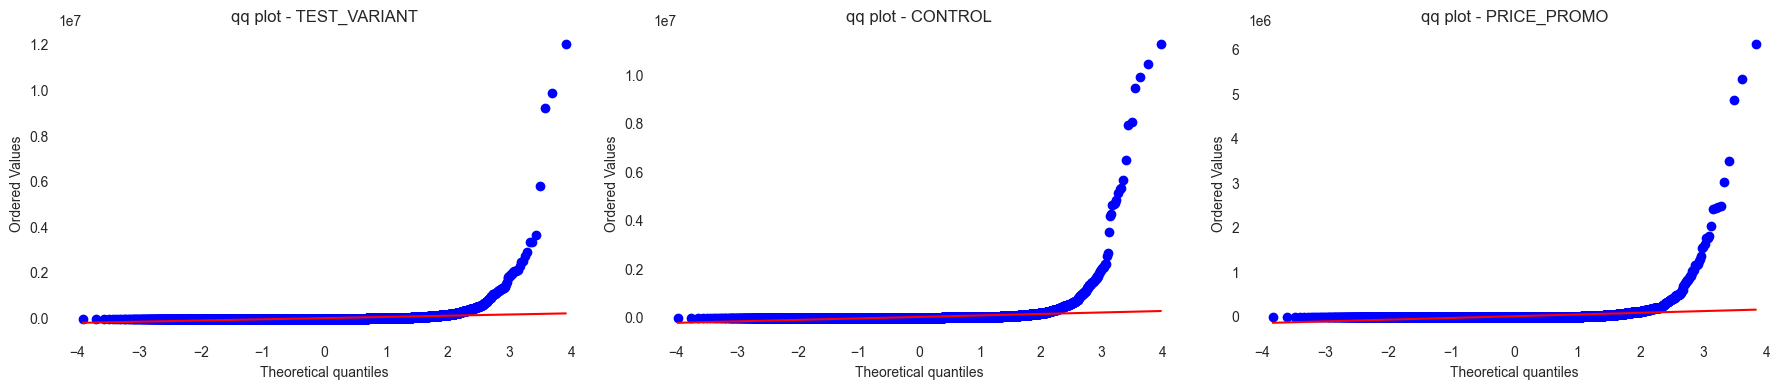

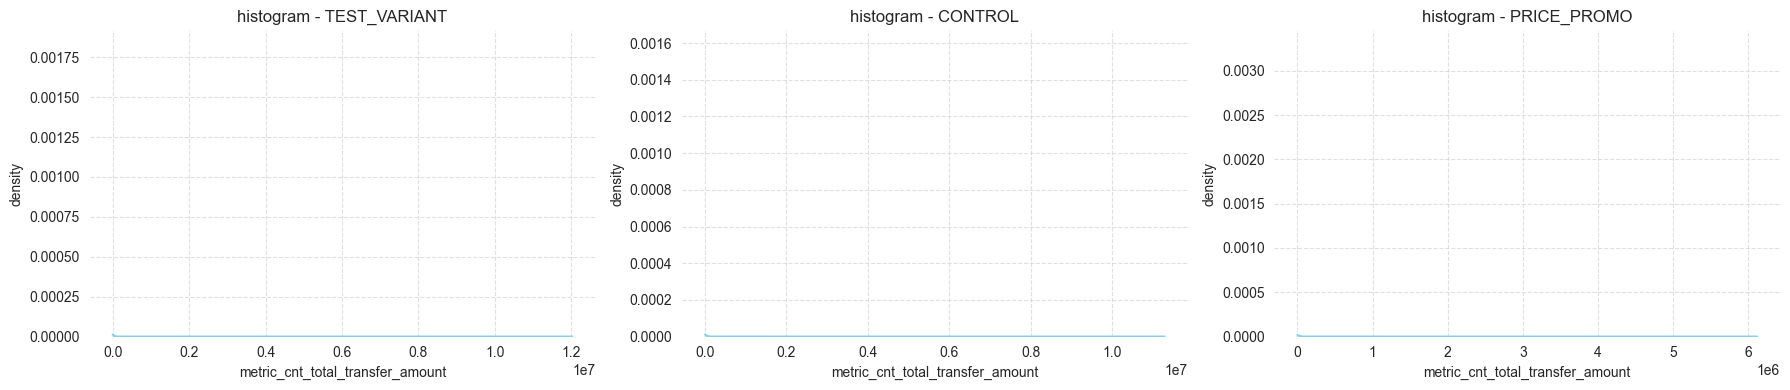

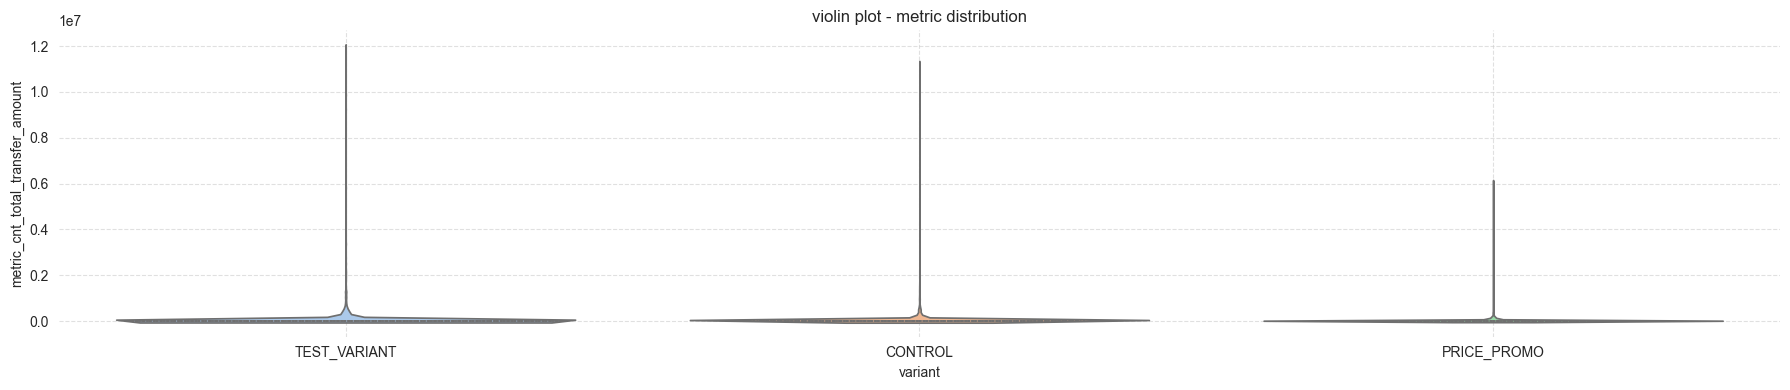

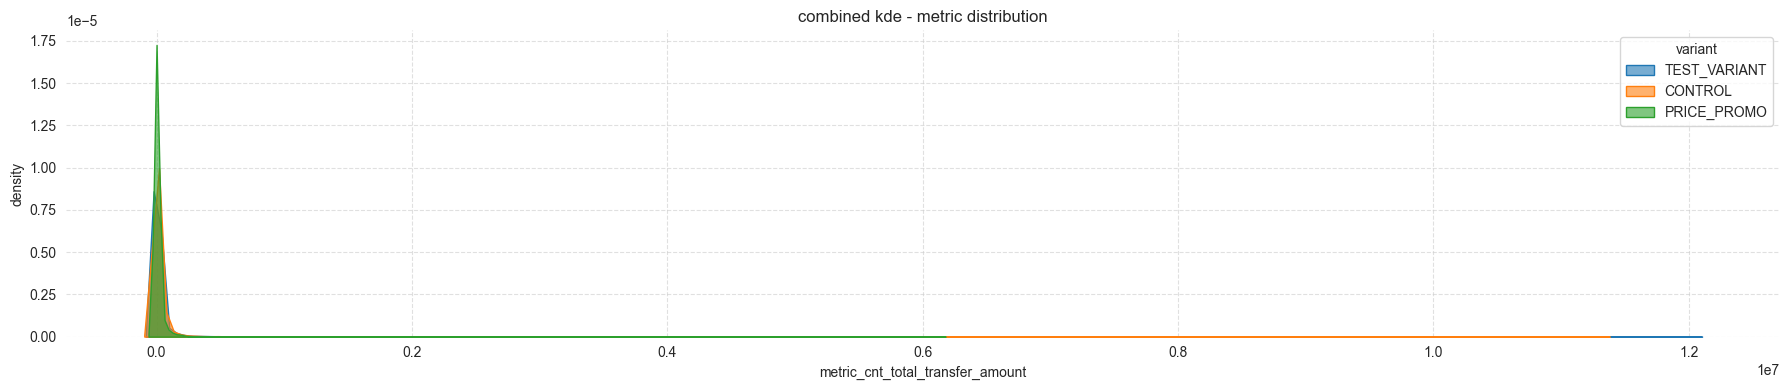

------------------------------------------------------------------------- NORMAL DISTRIBUTION TEST RESULTS -------------------------------------------------------------------------
variant TEST_VARIANT: normaltest statistic = 42931.4324, p-value = 0.0000
variant CONTROL: normaltest statistic = 50549.5064, p-value = 0.0000
variant PRICE_PROMO: normaltest statistic = 26648.8477, p-value = 0.0000

USE NORMAL DISTRIBUTION TESTS: False


In [181]:
print_title('NORMAL DISTRIBUTION VISUAL ANALYSIS', 180)
plot_qq(selected_df, variant_column, metric_column)
plot_histogram_kde(selected_df, variant_column, metric_column)
plot_violin(selected_df, variant_column, metric_column)
plot_combined_kde(selected_df, variant_column, metric_column)

print_title('NORMAL DISTRIBUTION TEST RESULTS', 180)
distribution_results = calculate_distribution(selected_df, variant_column, metric_column)

is_normal_distribution = set_normal_distribution_flag(distribution_results, alpha=0.05)
print(f'\nUSE NORMAL DISTRIBUTION TESTS: {is_normal_distribution}')

### SAMPLE VARIANCES

In [155]:
def calculate_variance_analysis(selected_df, variant_column, metric_column, alpha=0.05):
    # Levene's test for homogeneity of variances
    variants = selected_df[variant_column].unique()
    groups = [selected_df.loc[selected_df[variant_column] == variant, metric_column] for variant in variants]
    stat, p_value = stats.levene(*groups, center='median')
    is_equal_variance = p_value > alpha
    print(f"Levene test statistic = {stat:.4f}, p_value = {p_value:.4f}")
    print(f"Equal variance assumption: {is_equal_variance}")
    return {'test': 'levene', 'stat': stat, 'p_value': p_value, 'is_equal_variance': is_equal_variance}

def set_equal_variance_flag(variance_results, alpha=0.05):
    # Set flag for equal variance based on p_value > alpha
    is_equal_variance = variance_results['p_value'] > alpha
    return is_equal_variance

In [157]:
print_title('VARIANCE TEST RESULTS', 180)
variance_results = calculate_variance_analysis(selected_df, variant_column, metric_column)

is_equal_variance = set_equal_variance_flag(variance_results, alpha=0.05)
print(f'\nUSE EQUAL VARIANCE TESTS: {is_equal_variance}')

------------------------------------------------------------------------------ VARIANCE TEST RESULTS ------------------------------------------------------------------------------
Levene test statistic = 2.6214, p_value = 0.1054
Equal variance assumption: True

USE EQUAL VARIANCE TESTS: True


## STATISTICAL TESTING

### TEST AND TECHNICHES SELECTION

In [158]:
def configure_ab_test(metric_type, is_equal_variance, is_normal_distribution, num_variants, variant_ratio, sample_sizes, is_strong_outlier_effect, size_threshold = 30):
    print(f'metric_type: {metric_type}')
    print(f'is_normal_distribution: {is_normal_distribution}')
    print(f'is_equal_variance: {is_equal_variance}')
    print(f'num_variants: {num_variants}')
    print(f'sample_sizes: {sample_sizes}')
    print(f'variant_ratio: {np.round(variant_ratio, 2)}')
    print(f'is_strong_outlier_effect: {is_strong_outlier_effect}')
    
    ab_test_config = {
        # Bi variant tests
        "use_mann_whitney_u_test": False, # continuous, not normal, works with unbalanced samples
        "use_welchs_t_test": False, # continuous, normal, different variances, works with unbalanced samples (if low unbalance applied although same variants)
        "use_t_test": False, # continuous, normal, equal variances, not recommended if unbalanced
        "use_fisher_exact_test": False, # proportions, small sample size, works with unbalanced samples, # for proportions, only size matters due to central limit theorem
        "use_two_proportion_z_test": False, # proportions, large sample size, works with unbalanced samples, used alone or post Pearson Chi-square with Bonferroni for multiple variants, # for proportions, only size matters due to central limit theorem
        ## Multiple variants tests
        "use_anova_test": False, # continuous, normal, not recommended if unbalanced, equal variance
        "use_welch_anova_test": False, # continuous, normal, if unbalanced, different variance
        "use_kruskal_wallis_test": False, # continuous, not normal, works with unbalanced samples
        "use_pearson_chi_square_test": False, # proportions, works with unbalanced samples but needs correction
        ## Multiple variants post-pairs tests
        "use_tukey_hsd_test": False, # post anova, continuous, not recommended if unbalanced
        "use_games_howell_test": False, # post anova, continuous, for unbalanced samples
        "use_dunn_test": False, # post kruskal wallis, continuous, needs bonferroni, works with unbalanced samples
        ## Multiple variants correction
        "use_bonferroni_correction": False, # if more than 2 variants and tukey pr games howell is not used
        ## Unbalance data: N = A/B, if N < 2.5 use normal testing, if N < 5x use balance resampling, if N > 5x use bootstraping
        "use_balance_resampling": False, # for unbalanced sample sizes, equalizing groups, downsampling,
        "use_bootstraping": False, # for small sample sizes or unbalanced groups, estimating confidence intervals, upsampling,
        ## Additional techniques
        "use_bayesian_test": False, # for probabilistic interpretation, alternative to p-values, small samples
        "use_permutation_test": False # for distribution-free significance testing, alternative to t-tests or z-tests, extrange distributions
    }
    
    # Unbalance techniques
    if variant_ratio >= 2.5 and variant_ratio < 5:
        ab_test_config["use_balance_resampling"] = True
    elif variant_ratio >= 5:
        ab_test_config["use_bootstraping"] = True

    if metric_type == 'continuous':
        # Bi variant tests
        if num_variants == 2:
            if not is_normal_distribution:
                ab_test_config["use_mann_whitney_u_test"] = True
            else:
                if is_equal_variance:
                    if variant_ratio < 1.5:
                        ab_test_config["use_t_test"] = True 
                    elif 1.5 <= variant_ratio <= 2.5:
                        ab_test_config["use_welchs_t_test"] = True 
                    else:  
                        ab_test_config["use_t_test"] = True
                else:
                    ab_test_config["use_welchs_t_test"] = True 
        # Multiple variant tests
        elif num_variants > 2:
            if is_normal_distribution:
                if is_equal_variance:
                    if variant_ratio < 1.5:
                        ab_test_config["use_anova_test"] = True
                        ab_test_config["use_tukey_hsd_test"] = True
                    elif 1.5 <= variant_ratio <= 2.5:
                        ab_test_config["use_welch_anova_test"] = True
                        ab_test_config["use_games_howell_test"] = True
                    else:  # variant_ratio > 2.5
                        ab_test_config["use_anova_test"] = True
                        ab_test_config["use_tukey_hsd_test"] = True 
                else:
                    ab_test_config["use_welch_anova_test"] = True
                    ab_test_config["use_games_howell_test"] = True  
            else:
                ab_test_config["use_kruskal_wallis_test"] = True
                ab_test_config["use_dunn_test"] = True
            
            if not (ab_test_config["use_tukey_hsd_test"] or 
                    ab_test_config["use_games_howell_test"]) or ab_test_config["use_dunn_test"]:
                ab_test_config["use_bonferroni_correction"] = True

    # Proportions metric
    elif metric_type == 'proportion':
        # Bi variant tests
        if num_variants == 2:
            if sample_sizes.min() < size_threshold:
                ab_test_config["use_fisher_exact_test"] = True
            else:
                ab_test_config["use_two_proportion_z_test"] = True
        # Multiple variant tests
        elif num_variants > 2:
            ab_test_config["use_pearson_chi_square_test"] = True
            ab_test_config["use_two_proportion_z_test"] = True
            ab_test_config["use_bonferroni_correction"] = True

    # Additional techniques for small sample sizes (threshold < size_threshold)
    if sample_sizes.min() < 1000 or not is_normal_distribution:
        ab_test_config["use_bayesian_test"] = True
        
    if sample_sizes.min() < 100 or (is_strong_outlier_effect and sample_sizes.min() < 2000):
        ab_test_config["use_permutation_test"] = True
    return ab_test_config

In [183]:
print_title('TEST VARIABLES', 60)
ab_test_config = configure_ab_test(metric_type, is_equal_variance, is_normal_distribution, num_variants, variant_ratio, sample_sizes, is_strong_outlier_effect)
print('\n')
print_title('TEST SELECTION', 60)
print({key: value for key, value in ab_test_config.items() if value})

---------------------- TEST VARIABLES ----------------------
metric_type: continuous
is_normal_distribution: False
is_equal_variance: True
num_variants: 3
sample_sizes: VARIANT
CONTROL         19576
TEST_VARIANT    15205
PRICE_PROMO     10835
Name: count, dtype: int64
variant_ratio: 1.81
is_strong_outlier_effect: True


---------------------- TEST SELECTION ----------------------
{'use_kruskal_wallis_test': True, 'use_dunn_test': True, 'use_bonferroni_correction': True, 'use_bayesian_test': True}


### UNBALANCE DATA

### TESTS

In [171]:
def run_t_test(df, variant_column, metric_column):
    variants = df[variant_column].unique()
    groupA = df[df[variant_column] == variants[0]][metric_column]
    groupB = df[df[variant_column] == variants[1]][metric_column]
    stat, p_value = ttest_ind(groupA, groupB, equal_var=True)
    return {"stat": stat, "p_value": p_value}

def run_welchs_t_test(df, variant_column, metric_column):
    variants = df[variant_column].unique()
    groupA = df[df[variant_column] == variants[0]][metric_column]
    groupB = df[df[variant_column] == variants[1]][metric_column]
    stat, p_value = ttest_ind(groupA, groupB, equal_var=False)
    return {"stat": stat, "p_value": p_value}

def run_mann_whitney(df, variant_column, metric_column):
    variants = df[variant_column].unique()
    groupA = df[df[variant_column] == variants[0]][metric_column]
    groupB = df[df[variant_column] == variants[1]][metric_column]
    stat, p_value = mannwhitneyu(groupA, groupB, alternative='two-sided')
    return {"stat": stat, "p_value": p_value}

def run_two_proportion_z_test(df, variant_column, metric_column):
    success_counts = df.groupby(variant_column)[metric_column].sum().values
    total_counts = df.groupby(variant_column)[metric_column].count().values
    stat, p_value = proportions_ztest(success_counts, total_counts)
    return {"stat": stat, "p_value": p_value}

def run_fisher_exact_test(df, variant_column, metric_column):
    contingency_table = pd.crosstab(df[variant_column], df[metric_column])
    stat, p_value = fisher_exact(contingency_table)
    return {"stat": stat, "p_value": p_value}

#

def run_anova(df, variant_column, metric_column):
    groups = [df[df[variant_column] == variant][metric_column] for variant in df[variant_column].unique()]
    stat, p_value = f_oneway(*groups)
    return {"stat": stat, "p_value": p_value}

def run_welch_anova(df, variant_column, metric_column):
    res = pg.welch_anova(dv=metric_column, between=variant_column, data=df)
    return res

def run_kruskal_wallis(df, variant_column, metric_column):
    groups = [df[df[variant_column] == variant][metric_column] for variant in df[variant_column].unique()]
    stat, p_value = kruskal(*groups)
    return {"stat": stat, "p_value": p_value}

def run_chi_square(df, variant_column, metric_column):
    contingency_table = pd.crosstab(df[variant_column], df[metric_column])
    stat, p_value, _, _ = chi2_contingency(contingency_table)
    return {"stat": stat, "p_value": p_value}



def run_tukey_hsd(df, variant_column, metric_column):
    tukey = pairwise_tukeyhsd(endog=df[metric_column], groups=df[variant_column], alpha=0.05)
    return tukey.summary()

def run_games_howell(df, variant_column, metric_column):
    res = pg.pairwise_gameshowell(data=df, dv=metric_column, between=variant_column)
    return res

def run_dunn_test(df, variant_column, metric_column):
    res = sp.posthoc_dunn(df, val_col=metric_column, group_col=variant_column, p_adjust='bonferroni')
    return res

def apply_bonferroni_correction(p_values_matrix):
    p_values = p_values_matrix.values.flatten()
    mask = ~np.isnan(p_values)
    adjusted_p_values = multipletests(p_values[mask], method='bonferroni')[1]

    corrected_matrix = p_values_matrix.copy()
    corrected_matrix.values[mask] = adjusted_p_values
    return corrected_matrix


In [189]:
def run_ab_tests(test_config, df, variant_column, metric_column):
    results = {}

    # Continuous
    if test_config.get("use_t_test", False):
        results["t_test"] = run_t_test(df, variant_column, metric_column)
    if test_config.get("use_welchs_t_test", False):
        results["welchs_t_test"] = run_welchs_t_test(df, variant_column, metric_column)
    if test_config.get("use_mann_whitney_u_test", False):
        results["mann_whitney_u_test"] = run_mann_whitney(df, variant_column, metric_column)

    # Proportions
    if test_config.get("use_fisher_exact_test", False):
        results["fisher_exact_test"] = run_fisher_exact_test(df, variant_column, metric_column)
    if test_config.get("use_two_proportion_z_test", False):
        results["two_proportion_z_test"] = run_two_proportion_z_test(df, variant_column, metric_column)

    # Continuous - Multiple Variants
    if test_config.get("use_anova_test", False):
        results["anova_test"] = run_anova(df, variant_column, metric_column)
    if test_config.get("use_welch_anova_test", False):
        results["welch_anova_test"] = run_welch_anova(df, variant_column, metric_column)
    if test_config.get("use_kruskal_wallis_test", False):
        results["kruskal_wallis_test"] = run_kruskal_wallis(df, variant_column, metric_column)

    # Proportions - Multiple Variants
    if test_config.get("use_pearson_chi_square_test", False):
        results["pearson_chi_square_test"] = run_chi_square(df, variant_column, metric_column)

    return results

def run_post_hoc_tests(test_config, df, variant_column, metric_column):
    results = {}

    if test_config.get("use_tukey_hsd_test", False):
        results["tukey_hsd_test"] = run_tukey_hsd(df, variant_column, metric_column)
    if test_config.get("use_games_howell_test", False):
        results["games_howell_test"] = run_games_howell(df, variant_column, metric_column)

    if test_config.get("use_dunn_test", False):
        dunn_results = run_dunn_test(df, variant_column, metric_column)
        results["dunn_test"] = dunn_results
        if test_config.get("use_bonferroni_correction", False):
            results["bonferroni_correction"] = apply_bonferroni_correction(dunn_results)

    if test_config.get("use_pearson_chi_square_test", False):
        z_test_results = run_two_proportion_z_test(df, variant_column, metric_column)
        results["two_proportion_z_test"] = z_test_results
        if test_config.get("use_bonferroni_correction", False):
            results["bonferroni_correction"] = apply_bonferroni_correction(z_test_results)

    return results

SyntaxError: expected ':' (2154425118.py, line 33)

In [184]:
#ab_test_config['use_mann_whitney_u_test'] = False
#ab_test_config['use_fisher_exact_test'] = True
ab_test_config

{'use_mann_whitney_u_test': False,
 'use_welchs_t_test': False,
 'use_t_test': False,
 'use_fisher_exact_test': False,
 'use_two_proportion_z_test': False,
 'use_anova_test': False,
 'use_welch_anova_test': False,
 'use_kruskal_wallis_test': True,
 'use_pearson_chi_square_test': False,
 'use_tukey_hsd_test': False,
 'use_games_howell_test': False,
 'use_dunn_test': True,
 'use_bonferroni_correction': True,
 'use_balance_resampling': False,
 'use_bootstraping': False,
 'use_bayesian_test': True,
 'use_permutation_test': False}

In [187]:
def extract_p_value(json_data):
    first_key = next(iter(json_data))
    p_value = json_data[first_key].get("p_value")
    return p_value

In [188]:
alpha = 0.05
ab_test_results = run_ab_tests(ab_test_config, selected_df, variant_column, metric_column)
print(ab_test_results)
if num_variants > 2:
    p_value = extract_p_value(ab_test_results)
    print(p_value)
    if p_value < alpha:
        

{'kruskal_wallis_test': {'stat': 39.31915466242192, 'p_value': 2.8970370440258767e-09}}
2.8970370440258767e-09


In [182]:
selected_df

,U_ID,VARIANT,metric_cnt_total_transfer_amount
0,203,TEST_VARIANT,0.0
1,1577,TEST_VARIANT,0.0
2,3326,CONTROL,0.0
3,6004,CONTROL,0.0
4,8643,TEST_VARIANT,0.0
...,...,...,...
45618,45594,PRICE_PROMO,0.0
45619,45595,PRICE_PROMO,0.0
45620,45596,PRICE_PROMO,0.0
45621,45597,PRICE_PROMO,0.0


### ADDITIONAL TECHNIQUES

### SEGMENT ANALYSIS

In [20]:
## Segmentation
use_welchs_t_test_segmentation = False # for comparing two segments (A-New vs. B-New), continuous, normal, can unbalanced
use_mann_whitney_u_test_segmentation = False # for comparing two segments (A-New vs. B-New), continuous, not normal, can unbalanced
use_two_proportion_z_test_segmentation = False # for comparing two segments (A-New vs. B-New), proportions, large sample
use_fisher_exact_test_segmentation = False # for comparing two segments (A-New vs. B-New), proportions, small sample

## Interaction Tests, if discrepancies between segments
use_anova_interaction_test_segmentation = False # to test interaction effect between variant and segment, continuous, normal
use_welch_anova_interaction_test_segmentation = False # to test interaction effect between variant and segment, continuous, normal, can unbalanced
use_kruskal_wallis_interaction_test_segmentation = False # to test interaction effect between variant and segment, continuous, not normal
use_logistic_regression_interaction_test_segmentation = False # to test interaction effect for proportions, equivalent to ANOVA for categorical data
# if true, post hoc with tukey, games howell or dunn